## Codebase for bank marketing dataset classification using bagging techniques

Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import dataset

In [2]:
from dataset import get_data

df = get_data()
print(df.head())

        age  job  marital  education  default  housing  loan  contact  month  \
0  1.533034    3        1          0        0        0     0        1      6   
1  1.628993    7        1          3        1        0     0        1      6   
2 -0.290186    7        1          3        0        2     0        1      6   
3 -0.002309    0        1          1        0        0     0        1      6   
4  1.533034    7        1          3        0        0     2        1      6   

   day_of_week  ...  campaign     pdays  previous  poutcome  emp.var.rate  \
0            1  ... -0.565922  0.195414 -0.349494         1      0.648092   
1            1  ... -0.565922  0.195414 -0.349494         1      0.648092   
2            1  ... -0.565922  0.195414 -0.349494         1      0.648092   
3            1  ... -0.565922  0.195414 -0.349494         1      0.648092   
4            1  ... -0.565922  0.195414 -0.349494         1      0.648092   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

### Exploratory Data Analysis

Check Feature Type

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  float64
 1   job             41188 non-null  int64  
 2   marital         41188 non-null  int64  
 3   education       41188 non-null  int64  
 4   default         41188 non-null  int64  
 5   housing         41188 non-null  int64  
 6   loan            41188 non-null  int64  
 7   contact         41188 non-null  int64  
 8   month           41188 non-null  int64  
 9   day_of_week     41188 non-null  int64  
 10  duration        41188 non-null  float64
 11  campaign        41188 non-null  float64
 12  pdays           41188 non-null  float64
 13  previous        41188 non-null  float64
 14  poutcome        41188 non-null  int64  
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Check null values

In [4]:
print(df.isna().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


Check target variable distribution

In [5]:
print((df['y'] == 1).sum())
print((df['y'] == 0).sum())

4640
36548


### Data Preprocessing

Encode non-numerical feature

In [6]:
from sklearn.preprocessing import LabelEncoder

for feature in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']:
    df[feature] = LabelEncoder().fit_transform(df[feature])

Scaled numerical data

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for feature in ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']:
    df[feature] = scaler.fit_transform(df[[feature]])

Pipeline for preprocessing

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

X = df.drop(columns=['y'])
y = df['y']

def preprocessing_pipeline(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    smote_tomek = SMOTETomek(random_state=random_state)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

    return X_resampled, X_test, y_resampled, y_test

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


### Base Modelling

Baseline Model

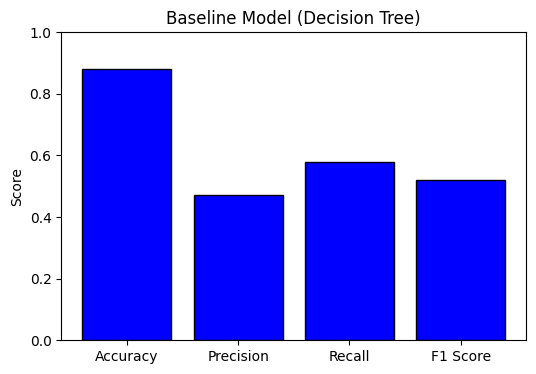

Accuracy: 0.8799
Recall: 0.5797
Precision: 0.4730
F1 Score: 0.5210
Confusion Matrix: TN=10066, FP=899, FN=585, TP=807


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

X_resampled, X_test, y_resampled, y_test = preprocessing_pipeline(X, y)

baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_resampled, y_resampled)

y_pred = baseline_model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color='blue', edgecolor='black')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Baseline Model (Decision Tree)')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

In [14]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

X_resampled, X_test, y_resampled, y_test = preprocessing_pipeline(X, y)


cv_scores = cross_val_score(
    baseline_model, X_resampled, y_resampled, cv=cv, scoring='accuracy'
)

cv_scores_f1 = cross_val_score(
    baseline_model, X_resampled, y_resampled, cv=cv, scoring='f1'
)

print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")
print(f"Std CV accuracy: {np.std(cv_scores):.4f}")
print(f"Mean CV F1 Score: {np.mean(cv_scores_f1):.4f}")
print(f"Std CV F1 Score: {np.std(cv_scores_f1):.4f}")

Mean CV accuracy: 0.9250
Std CV accuracy: 0.0044
Mean CV F1 Score: 0.9256
Std CV F1 Score: 0.0042


### Bagging Model

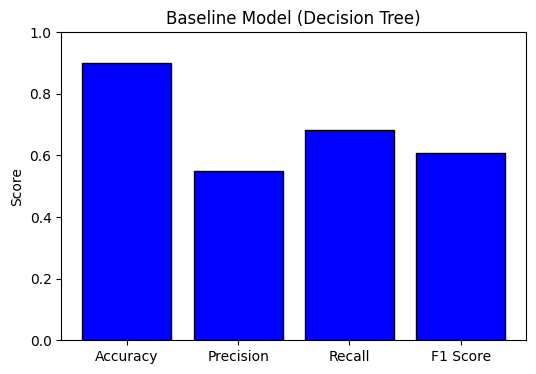

Accuracy: 0.9013
Recall: 0.6818
Precision: 0.5498
F1 Score: 0.6087
Confusion Matrix: TN=10066, FP=899, FN=585, TP=807


In [15]:
#Base model
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

X_resampled, X_test, y_resampled, y_test = preprocessing_pipeline(X, y)

base_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=None, random_state=42),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

base_bagging.fit(X_resampled, y_resampled)
y_pred = base_bagging.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color='blue', edgecolor='black')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Baseline Model (Decision Tree)')
plt.show()

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

CV Accuracy: 0.8911
CV Recall: 0.9299
CV Precision: 0.8629
CV F1 Score: 0.8951


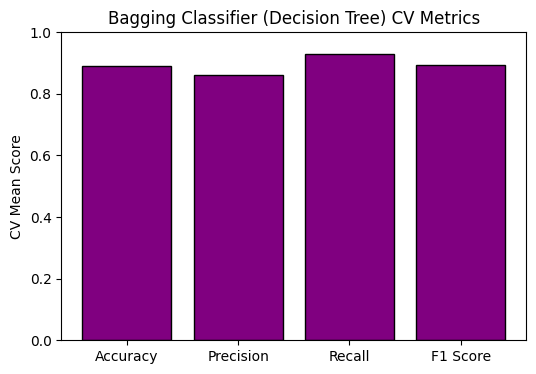

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

X_resampled, X_test, y_resampled, y_test = preprocessing_pipeline(X, y)

base_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

cv_acc = cross_val_score(base_bagging, X_resampled, y_resampled, cv=cv, scoring='accuracy')
cv_rec = cross_val_score(base_bagging, X_resampled, y_resampled, cv=cv, scoring='recall')
cv_prec = cross_val_score(base_bagging, X_resampled, y_resampled, cv=cv, scoring='precision')
cv_f1 = cross_val_score(base_bagging, X_resampled, y_resampled, cv=cv, scoring='f1')

print(f"CV Accuracy: {np.mean(cv_acc):.4f}")
print(f"CV Recall: {np.mean(cv_rec):.4f}")
print(f"CV Precision: {np.mean(cv_prec):.4f}")
print(f"CV F1 Score: {np.mean(cv_f1):.4f}")

# Plot histogram of CV metrics
cv_metrics = {
    "Accuracy": np.mean(cv_acc),
    "Precision": np.mean(cv_prec),
    "Recall": np.mean(cv_rec),
    "F1 Score": np.mean(cv_f1)
}

plt.figure(figsize=(6,4))
plt.bar(cv_metrics.keys(), cv_metrics.values(), color='purple', edgecolor='black')
plt.ylabel('CV Mean Score')
plt.ylim(0, 1)
plt.title('Bagging Classifier (Decision Tree) CV Metrics')
plt.show()

In [17]:
#Optimized bagging classifier using GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

params_grid = {
    'n_estimators': [10, 50, 100, 300, 500],
    'estimator__max_depth': [1, 3, 5, 8, 10]
}

bagging_optimized = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    random_state=42,
    n_jobs=-1
)

grid_cv = GridSearchCV(
    estimator=bagging_optimized,
    param_grid=params_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_cv.fit(X_resampled, y_resampled)

print(f"Best parameters: {grid_cv.best_params_}")
print(f"Best CV F1 Score: {grid_cv.best_score_:.4f}")

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best parameters: {'estimator__max_depth': 10, 'n_estimators': 300}
Best CV F1 Score: 0.9282


CV Accuracy: 0.9255
CV Recall: 0.9636
CV Precision: 0.8953
CV F1 Score: 0.9282


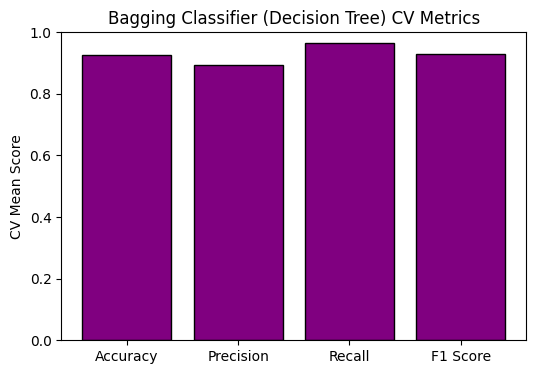

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

X_resampled, X_test, y_resampled, y_test = preprocessing_pipeline(X, y)

base_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

cv_acc = cross_val_score(base_bagging, X_resampled, y_resampled, cv=cv, scoring='accuracy')
cv_rec = cross_val_score(base_bagging, X_resampled, y_resampled, cv=cv, scoring='recall')
cv_prec = cross_val_score(base_bagging, X_resampled, y_resampled, cv=cv, scoring='precision')
cv_f1 = cross_val_score(base_bagging, X_resampled, y_resampled, cv=cv, scoring='f1')

print(f"CV Accuracy: {np.mean(cv_acc):.4f}")
print(f"CV Recall: {np.mean(cv_rec):.4f}")
print(f"CV Precision: {np.mean(cv_prec):.4f}")
print(f"CV F1 Score: {np.mean(cv_f1):.4f}")

# Plot histogram of CV metrics
cv_metrics = {
    "Accuracy": np.mean(cv_acc),
    "Precision": np.mean(cv_prec),
    "Recall": np.mean(cv_rec),
    "F1 Score": np.mean(cv_f1)
}

plt.figure(figsize=(6,4))
plt.bar(cv_metrics.keys(), cv_metrics.values(), color='purple', edgecolor='black')
plt.ylabel('CV Mean Score')
plt.ylim(0, 1)
plt.title('Bagging Classifier (Decision Tree) CV Metrics')
plt.show()

Random Forest Model

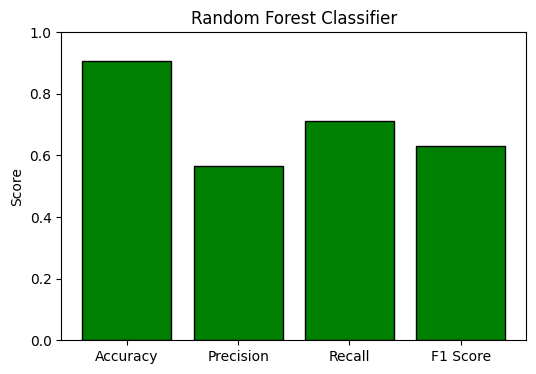

Accuracy: 0.9057
Recall: 0.7112
Precision: 0.5647
F1 Score: 0.6296


In [19]:
#Base model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

X_resampled, X_test, y_resampled, y_test = preprocessing_pipeline(X, y)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_resampled, y_resampled)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}  

plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color='green', edgecolor='black')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Random Forest Classifier')
plt.show()
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")

In [20]:
#Optimized GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

X_resampled, X_test, y_resampled, y_test = preprocessing_pipeline(X, y)

params_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_features': ['sqrt', 'log2', None],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_cv = GridSearchCV(
    estimator=rf,
    param_grid=params_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_cv.fit(X_resampled, y_resampled)
print(f"Best parameters: {grid_cv.best_params_}")
print(f"Best CV F1 Score: {grid_cv.best_score_:.4f}")

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best parameters: {'max_features': 'sqrt', 'n_estimators': 100}
Best CV F1 Score: 0.9538


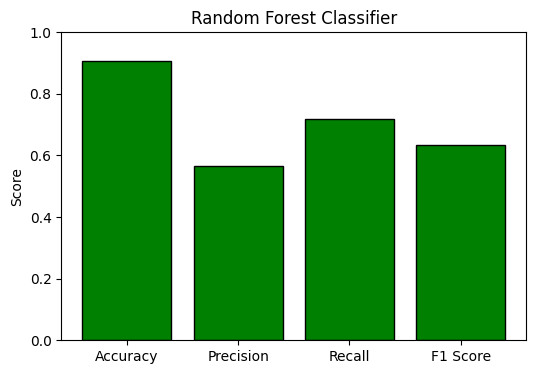

Accuracy: 0.9063
Recall: 0.7191
Precision: 0.5662
F1 Score: 0.6335


In [ ]:
#Optimized model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

X_resampled, X_test, y_resampled, y_test = preprocessing_pipeline(X, y)

rf = RandomForestClassifier(n_estimators=500, max_features='sqrt', random_state=42, n_jobs=-1)
rf.fit(X_resampled, y_resampled)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = {
    "Accuracy": acc,   
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}  

plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color='green', edgecolor='black')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Random Forest Classifier')
plt.show()
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1 Score: {f1:.4f}")

### Best Model